In [1]:
import matplotlib.pyplot as plt
import mpl_lego as mplego
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from functools import partial
from mpl_lego.labels import bold_text, apply_subplot_labels
from scipy.stats import bootstrap
from pyprojroot import here
from sklearn.metrics import f1_score
from tqdm import tqdm

from moral_foundations_llms import keys
 
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', 0)

In [3]:
mplego.style.use_latex_style()

In [4]:
df = pd.read_csv(here('data/aita_final_v29.csv'))

In [5]:
# Calculate bootstrap estimates
def label_difference(records, model_moral_label_col, model_verdict_col, aita_label):
    # Get the column indicating whether each row falls in the moral scenario
    model_moral_label = records[model_moral_label_col]
    # Get the column indicating what the model assigned that scenario as a verdict
    model_verdicts = records[model_verdict_col]
    # Moral scenario is true: what fraction of time did model assign the aita_label?
    scenario_true_prop = (model_verdicts[model_moral_label] == aita_label).mean()
    # Moral scenario is not true: what fraction of time did model assign the aita_label?
    scenario_false_prop = (model_verdicts[~model_moral_label] == aita_label).mean()
    # Calculate difference in proportions
    diff = scenario_true_prop - scenario_false_prop
    return diff

In [ ]:
bounds = {moral_axis:
          [[bootstrap((df[[f'{reason_col}_{moral_axis}_label', model_verdict_col]].to_records(index=False),),
          partial(label_difference,
                  model_moral_label_col=f'{reason_col}_{moral_axis}_label',
                  model_verdict_col=model_verdict_col,
                  aita_label=aita_label))
          # Calculate label difference for each AITA label
          for aita_label in keys.AITA_LABELS]
          # For each moral axis, calculate the label difference for the model
          for reason_col, model_verdict_col in zip(keys.REASON_COLS, keys.LABEL_COLS)]
          # Iterate over each moral axis
          for moral_axis in tqdm(keys.MORAL_AXES)}

In [47]:
with open('reasons_bootstraps.pkl', 'wb') as file:
    pickle.dump(bounds, file)

In [7]:
with open('reasons_bootstraps.pkl', 'rb') as file:
    bounds = pickle.load(file)

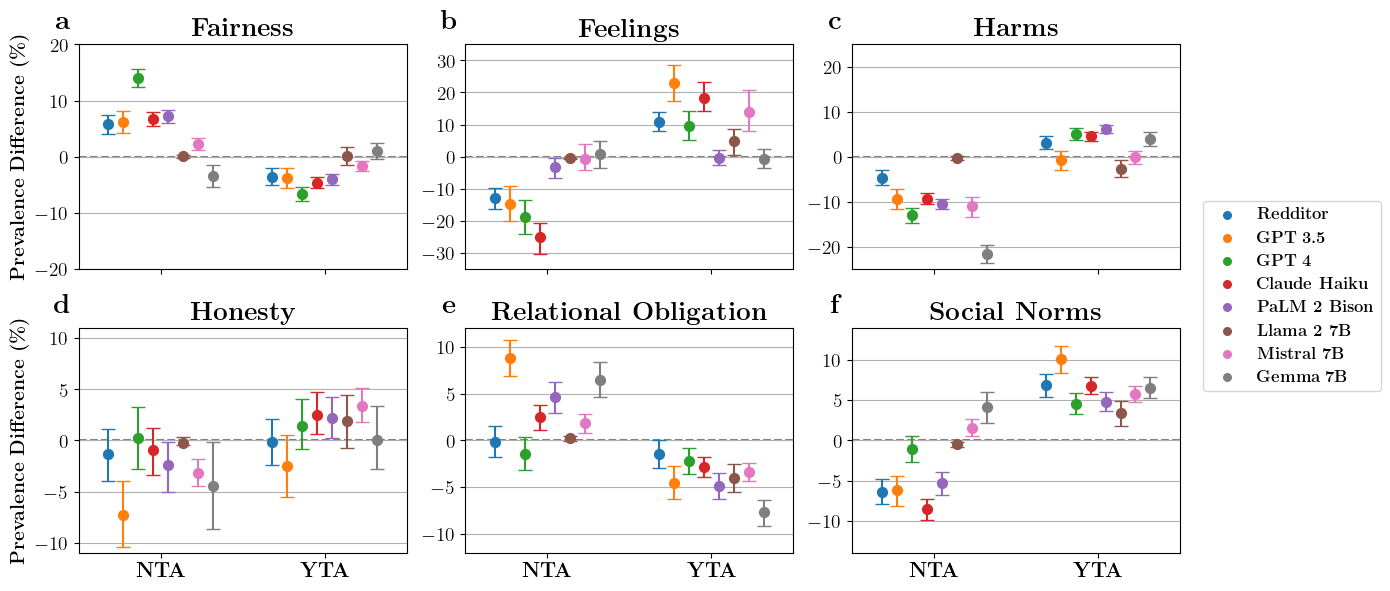

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True)

jitter = np.linspace(-0.32, 0.32, 8)
axes_list = axes.ravel()

for moral_idx, (moral, bound) in enumerate(bounds.items()):
    for aita_idx in range(2):
        for model in range(len(keys.MODELS)):
            interval = bound[model][aita_idx]
            mean = 100 * interval.bootstrap_distribution.mean()
            low = 100 * interval.confidence_interval.low
            high = 100 * interval.confidence_interval.high
            axes_list[moral_idx].scatter(aita_idx + jitter[model], mean, color=f'C{model}', s=50)
            axes_list[moral_idx].errorbar(aita_idx + jitter[model], mean, yerr=[[mean - low], [high - mean]], capsize=5, color=f'C{model}')

            axes_list[moral_idx].set_title(bold_text(keys.MORAL_AXES_LABELS_PLOT[moral_idx]), fontsize=19)    

for idx, (model, model_label) in enumerate(zip(keys.MODELS, keys.MODEL_LABELS_PLOT)):
    axes[1, -1].scatter(-1, 0, color=f'C{idx}', label=bold_text(model_label), s=30)

fig.legend(loc='center left',
           bbox_to_anchor=(1.0, 0.5),
           prop={'size': 12},
           ncol=1)

for ax in axes_list:
    ax.set_ylim([-20, 20])
    ax.set_xticks([0, 1])
    ax.set_xlim([-0.5, 1.5])
    ax.axhline(0, linestyle='--', color='gray', zorder=-10000)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_xticklabels(bold_text(['NTA', 'YTA']), fontsize=15)
    ax.set_yticks([-20, -10, 0, 10, 20])


axes[0, 0].set_ylim([-20, 20])
axes[0, 1].set_ylim([-35, 35])
axes[0, 1].set_yticks([-30, -20, -10, 0, 10, 20, 30])
axes[0, 2].set_ylim([-25, 25])
axes[1, 0].set_ylim([-11, 11])
axes[1, 0].set_yticks([-10, -5, 0, 5, 10])
axes[1, 1].set_ylim([-12, 12])
axes[1, 1].set_yticks([-10, -5, 0, 5, 10])
axes[1, 2].set_ylim([-14, 14])
axes[1, 2].set_yticks([-10, -5, 0, 5, 10])

for ax in axes[:, 0]:
    ax.set_ylabel(bold_text('Prevalence Difference (\%)'), fontsize=14)

for ax in axes_list:
    ax.tick_params(axis='y', labelsize=14)

apply_subplot_labels(axes, bold=True, x=-0.05, y=1.1, size=20)
plt.tight_layout()
plt.savefig('reasons.pdf', bbox_inches='tight')